# Загрузка данных

In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, metrics
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

import os

In [2]:
# Пути к изображениям
train_dir = 'data/train'
val_dir = 'data/val'
test_dir = 'data/test'

# Для удобства данные загружаем батчами. Для этого сразу указываем таргетный размер
target_size = (224, 224)
batch_size = 32

In [3]:
# Загружаем тренировочную выборку
train_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=target_size,
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,    # Для тренировочной выборки. Для остальных не надо
    seed=42
)

Found 5216 files belonging to 2 classes.


In [4]:
# Загружаем валидационную выборку
val_ds = keras.utils.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=target_size,
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
    seed=42
)

Found 16 files belonging to 2 classes.


In [5]:
# Загружаем тестовую выборку
test_ds = keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=target_size,
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
    seed=42
)

Found 624 files belonging to 2 classes.


In [6]:
# Проверяем правильно ли отображаются классы
class_names = train_ds.class_names
print(f'Названия классов: {class_names}')

Названия классов: ['NORMAL', 'PNEUMONIA']


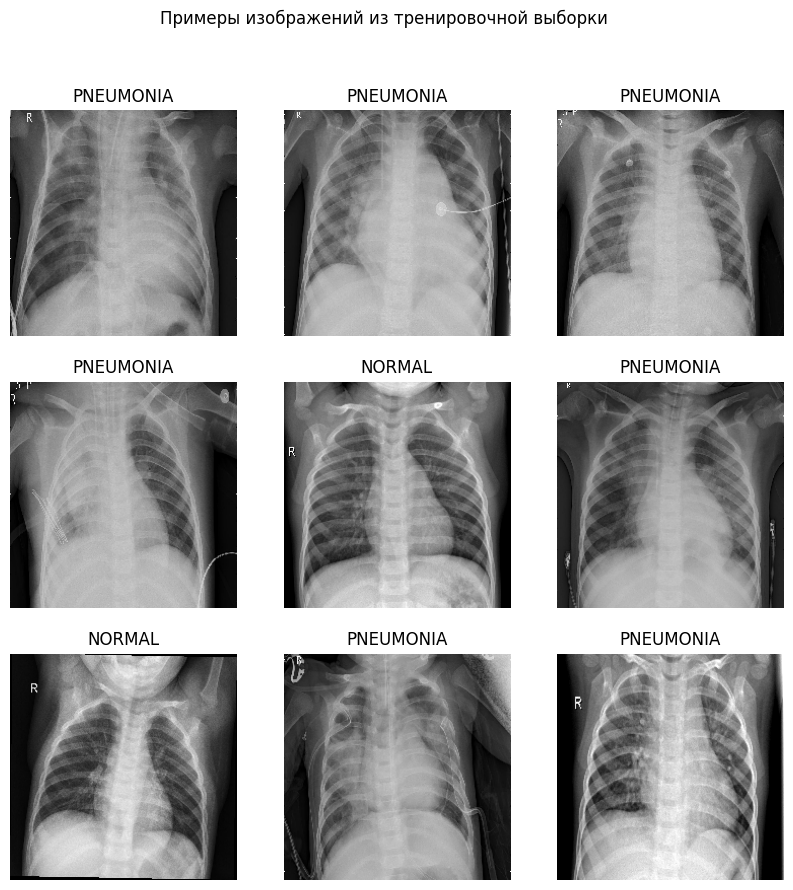

In [7]:
# Визуализируем рандомные 9 загруженных изображений
# для проверки корректности загрузки
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i].numpy())])
        plt.axis("off")
    plt.suptitle("Примеры изображений из тренировочной выборки")
    plt.show()

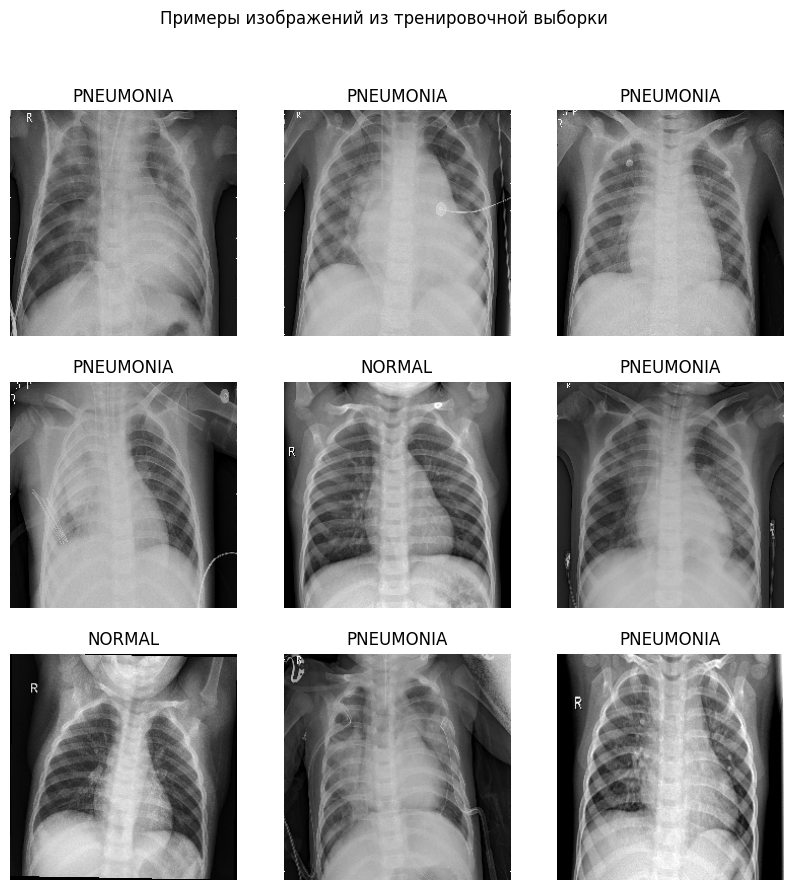

# EDA
Для начала необходимо посмотреть на распределение классов, чтобы понять сбалансированность датасета.

In [8]:
def count_class_distribution(dataset, class_names):
    '''
    Input:
    `dataset` - keras датасет с изображениями.
    `class_names` - категории в подаваемом датасете, по которым производится подсчёт.

    Output:
    `(class_counts, total_images)`, где
    `class_counts` - словарь в формате `категория : количество в датасете`
    `total_images` - общее количество изображений в датасете
    '''
    class_counts = {name: 0 for name in class_names}
    total_images = 0

    for image, labels in dataset:
        for label in labels.numpy():
            class_index = np.argmax(label)
            class_name = class_names[class_index]
            class_counts[class_name] += 1
            total_images += 1
    
    return class_counts, total_images

In [9]:
# Проверим распределение классов тренировочной выборки
train_class_counts, train_total_imgs = count_class_distribution(train_ds, class_names)

for class_name, count in train_class_counts.items():
    print(f'{class_name}: {count} изображений ({count / train_total_imgs * 100:.2f} %)')

NORMAL: 1341 изображений (25.71 %)
PNEUMONIA: 3875 изображений (74.29 %)


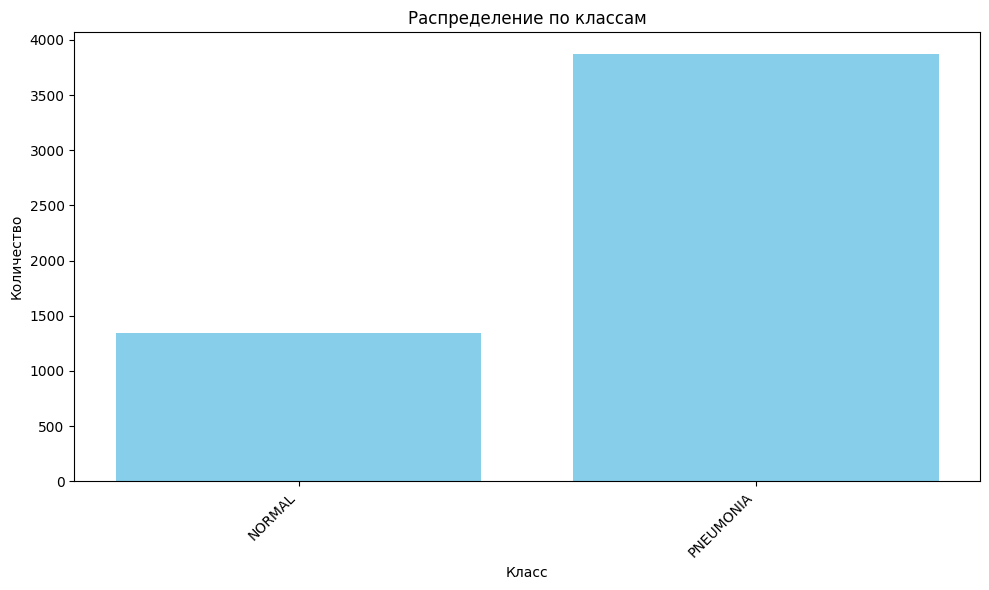

In [10]:
# Визуализируем распределение классов
plt.figure(figsize=(10, 6))
plt.bar(train_class_counts.keys(), train_class_counts.values(), color='skyblue')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.title('Распределение по классам')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

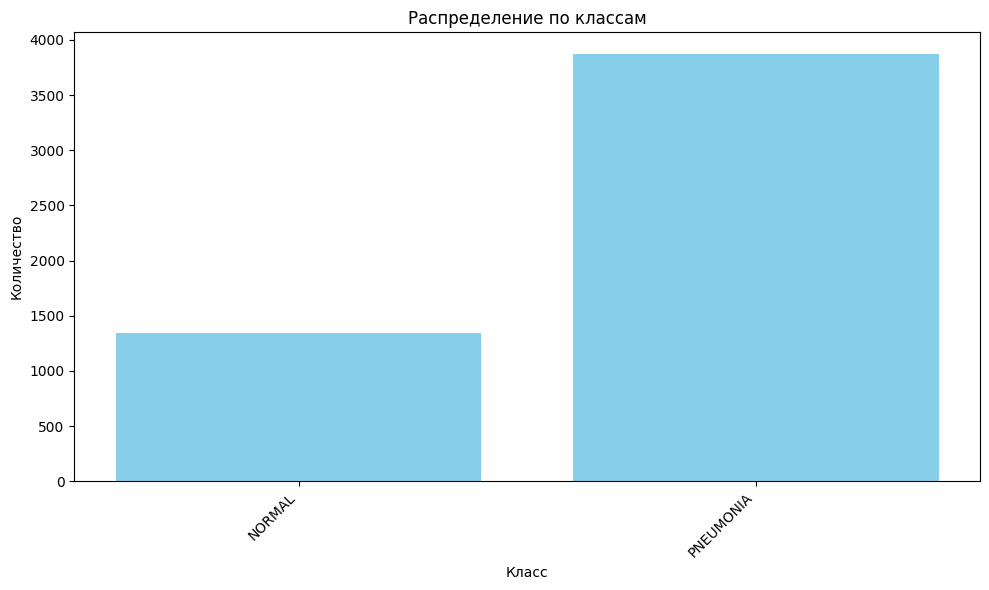

По результатам EDA виден сильный дисбаланс классов, что при обучении модели будет вызывать её "перевес" в сторону классов с бОльшим количеством изображений на этапе обучения.  
Для исправления дисбаланса следует провести аугментацию (например, добавить шума, поворот изображений и т.д.)

# Предобработка
Изображения уже приведены к размеру 224 на 224, поэтому для балансировки классов произведём взвешивание классов.

In [11]:
class_weights = {}
for i in class_names:
    count = train_class_counts[i]
    if count == 0:
        class_weights[i] = 0.0
    else:
        class_weights[i] = train_total_imgs / (count * len(class_names))

print('Веса классов:')
for key, weight in class_weights.items():
    print(f'    Класс {key}: {weight:.2f}')

Веса классов:
    Класс NORMAL: 1.94
    Класс PNEUMONIA: 0.67


Проведём аугментацию для улучшения устойчивости модели.

In [12]:
# Слой для поворота изображения
rotation_layer = tf.keras.layers.RandomRotation(
    factor=10.0 / 360.0,
    fill_mode='nearest'
)

def augment_image(image, label):
    image = tf.cast(image, tf.float32)

    # Случайно изменим яркость и контраст
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    # Добавим Гауссов шум
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.05)
    image = image + noise
    image = tf.clip_by_value(image, 0.0, 255.0)

    # Поворот на +- 10 градусов
    image = rotation_layer(image)

    return image, label

augmented_train_ds = train_ds.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
augmented_train_ds = augmented_train_ds.prefetch(tf.data.AUTOTUNE)

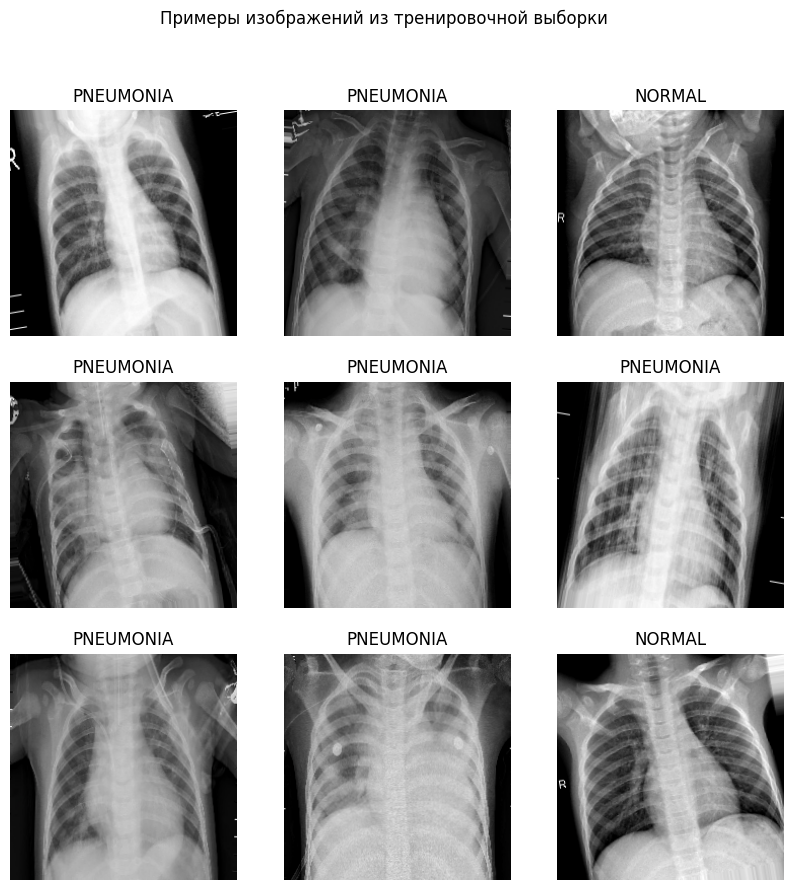

In [13]:
# Визуализируем рандомные 9 аугментированных изображений
# для проверки корректности аугментации
for images, labels in augmented_train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i].numpy())])
        plt.axis("off")
    plt.suptitle("Примеры изображений из тренировочной выборки")
    plt.show()

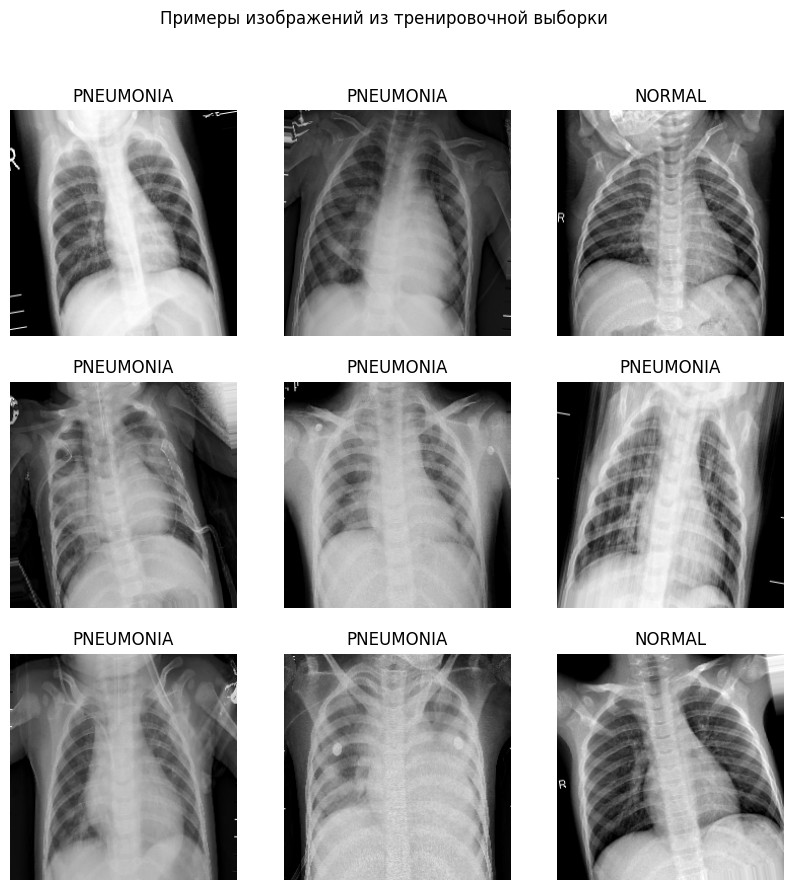

Теперь данные необходимо нормализовать для избежания переобучения и улучшения сходимости.

In [14]:
# Создадим слой для нормализации
norm_layer = tf.keras.layers.Rescaling(scale=1./127.5, offset=-1)

# И нормализуем данные для каждой из выборок
norm_train_ds = augmented_train_ds.map(lambda x, y: (norm_layer(x), y))
norm_val_ds = val_ds.map(lambda x, y: (norm_layer(x), y))
norm_test_ds = test_ds.map(lambda x, y: (norm_layer(x), y))

# Проверим нормализованные данные на примере тренировочной выборки
for images, labels in norm_train_ds.take(1):
    print(f'Минимальное значение пикселя: {tf.reduce_min(images).numpy():.4f}')
    print(f'Максимальное значение пикселя: {tf.reduce_max(images).numpy():.4f}')

Минимальное значение пикселя: -0.9751
Максимальное значение пикселя: 0.9601


# Базовая модель

In [39]:
num_classes = len(class_names)

# Входной размер 224 на 224 на 3 канала для цвета
input_shape = (224, 224, 3)

# Базовая CNN
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.MaxPooling2D((2, 2)),
    
    # Переводим данные в одномерное отображение
    layers.Flatten(),

    layers.Dense(32, activation='relu'),
    layers.Dropout(0.5),

    # Выходной слой
    layers.Dense(num_classes, activation='softmax')
])

model.summary()

c:\Main\VS_Code_projects\shkila\HW\DL\.venv311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_39 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │       692,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 785,570 (3.00 MB)

 Trainable params: 785,570 (3.00 MB)

 Non-trainable params: 0 (0.00 B)

В модели менее 1 млн параметров, поэтому можно двигаться дальше. Осталось скомпилировать её, добавить метрики, оптимизатор и функцию потерь.

In [40]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall'),
        metrics.AUC(name='roc_auc')
    ]
)

Для передачи весов в модель при обучении классы необходимо преобразовать в целочисленное отображение.

In [41]:
class_to_idx = {name: idx for idx, name in enumerate(class_names)}
print(f"Сопоставление классов с индексами: {class_to_idx}")

class_weights = {}
for class_name, count in train_class_counts.items():
    # Получаем целочисленный индекс для текущего имени класса
    class_idx = class_to_idx[class_name]

    if count == 0:
        class_weights[class_idx] = 0.0
    else:
        class_weights[class_idx] = train_total_imgs / (count * len(class_names))

print('Веса классов (с числовыми ключами):')
for key, weight in class_weights.items():
    print(f'    Класс {class_names[key]} (индекс {key}): {weight:.2f}')

Сопоставление классов с индексами: {'NORMAL': 0, 'PNEUMONIA': 1}
Веса классов (с числовыми ключами):
    Класс NORMAL (индекс 0): 1.94
    Класс PNEUMONIA (индекс 1): 0.67


Для эффективного обучения используем callback'и для ранней остановки при отсутствии улучшения модели на валидационной выборке и для сохранения лучшей модели.

In [45]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = keras.callbacks.ModelCheckpoint(
    'best_case_cnn_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

epochs = 15

# Обучаем модель с учётом ранее вычисленных весов
history = model.fit(
    norm_train_ds,
    validation_data=norm_val_ds,
    epochs=epochs,
    callbacks=[early_stopping, checkpoint],
    class_weight=class_weights
)

print('Done!')

Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.9098 - loss: 0.2687 - precision: 0.9098 - recall: 0.9098 - roc_auc: 0.9513
Epoch 1: val_accuracy improved from -inf to 0.75000, saving model to best_case_cnn_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 98s 595ms/step - accuracy: 0.9099 - loss: 0.2687 - precision: 0.9099 - recall: 0.9099 - roc_auc: 0.9514 - val_accuracy: 0.7500 - val_loss: 0.5432 - val_precision: 0.7500 - val_recall: 0.7500 - val_roc_auc: 0.8008
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.9257 - loss: 0.2287 - precision: 0.9257 - recall: 0.9257 - roc_auc: 0.9667
Epoch 2: val_accuracy improved from 0.75000 to 0.93750, saving model to best_case_cnn_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 565ms/step - accuracy: 0.9257 - loss: 0.2288 - precision: 0.9257 - recall: 0.9257 - roc_auc: 0.9667 - val_accuracy: 0.9375 - val_loss: 0.2974 - val_precision: 0.9375 - val_recall: 0.9375 - val_roc_auc: 0.9492
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━

Теперь загрузим лучшую модель и выведем метрики.

In [46]:
# Загружаем лучшую сохраненную модель
try:
    best_model = keras.models.load_model('best_base_cnn_model.keras')
    print("\nЛучшая модель успешно загружена.")
except Exception as e:
    print(f"\nНе удалось загрузить лучшую модель: {e}")
    print("Используем текущую модель после обучения.")
    best_model = model  # Если загрузка не удалась, используем модель, которая есть в памяти

print("\nОценка модели на тестовой выборке:")
test_results = best_model.evaluate(norm_test_ds)

# Вывод метрик, полученных во время оценки
print("\nКлючевые метрики на тестовой выборке (из Keras evaluate):")
for name, value in zip(best_model.metrics_names, test_results):
    print(f"- {name}: {value:.4f}")

# Для F1-score и более детального Precision/Recall/AUC, используем scikit-learn
print("\nРасчет дополнительных метрик с scikit-learn:")
y_pred_probs = best_model.predict(norm_test_ds)
y_true_one_hot = tf.concat([labels for _, labels in norm_test_ds], axis=0).numpy()

y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_true_one_hot, axis=1)

# Precision, Recall, F1-score
print(f"- Precision (weighted): {precision_score(y_true_classes, y_pred_classes, average='weighted'):.4f}")
print(f"- Recall (weighted): {recall_score(y_true_classes, y_pred_classes, average='weighted'):.4f}")
print(f"- F1-score (weighted): {f1_score(y_true_classes, y_pred_classes, average='weighted'):.4f}")

# ROC-AUC
try:
    auc_score = roc_auc_score(y_true_classes, y_pred_probs[:, 1])
    print(f"- ROC-AUC (Binary): {auc_score:.4f}")
except ValueError as e:
    print(f"Не удалось рассчитать ROC-AUC с scikit-learn: {e}.")


Не удалось загрузить лучшую модель: File not found: filepath=best_base_cnn_model.keras. Please ensure the file is an accessible `.keras` zip file.
Используем текущую модель после обучения.

Оценка модели на тестовой выборке:
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 208ms/step - accuracy: 0.7976 - loss: 0.4318 - precision: 0.7976 - recall: 0.7976 - roc_auc: 0.9071

Ключевые метрики на тестовой выборке (из Keras evaluate):
- loss: 0.2995
- compile_metrics: 0.8750

Расчет дополнительных метрик с scikit-learn:
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step
- Precision (weighted): 0.8868
- Recall (weighted): 0.8750
- F1-score (weighted): 0.8698
- ROC-AUC (Binary): 0.9624


Теперь визуализируем результаты обучения.

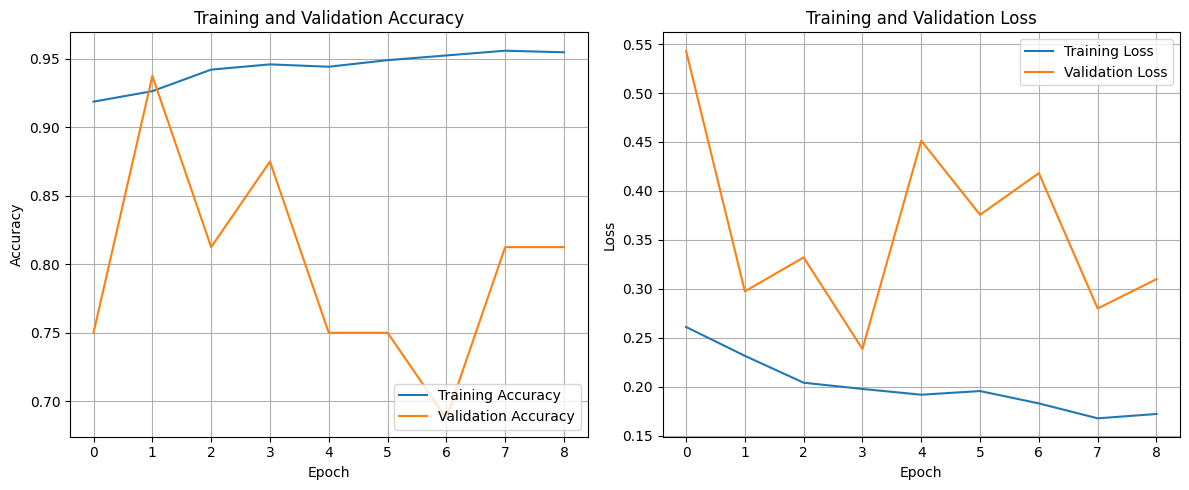

In [47]:
# Получаем данные из объекта history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.tight_layout()
plt.show()

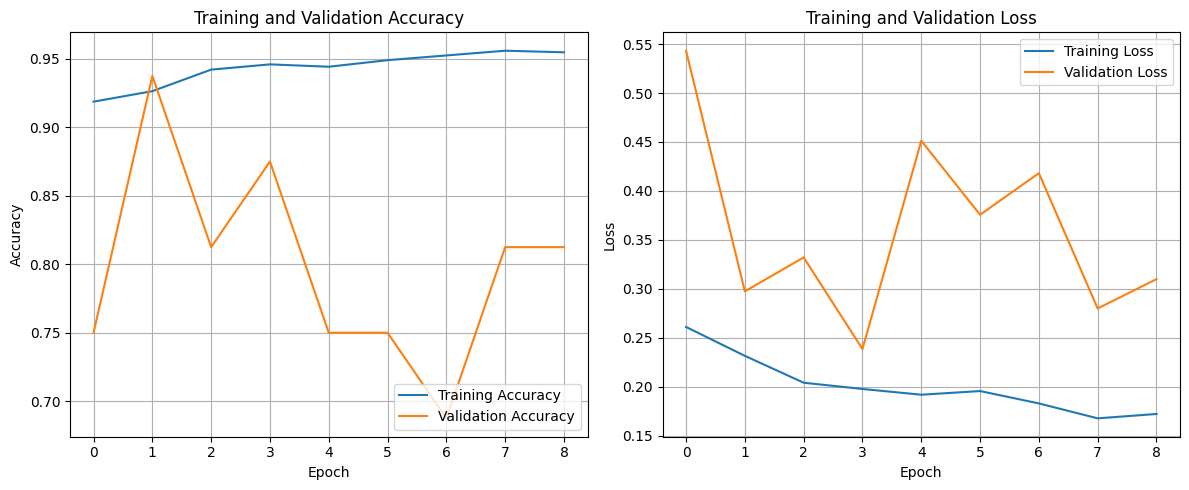

- График **Training and Validation Accuracy**: Тренировочная точность стабильно росла, достигнув примерно 0.96. Валидационная точность колебалась, достигнув пика около 0.93 на ранних этапах, а затем демонстрируя значительные флуктуации и снижение к концу обучения. Это может указывать на начало переобучения, несмотря на использование Dropout и EarlyStopping, или на сложности в данных валидации.  
- График **Training and Validation Loss**: Тренировочные потери последовательно снижались. Валидационные потери также снижались вначале, но затем начали колебаться и увеличиваться, что подтверждает наблюдения по точности и может сигнализировать о том, что модель начинает переобучаться на тренировочных данных и плохо обобщается на валидационном наборе.

## Оценка Производительности
Финальная оценка производительности модели была проведена на отложенной тестовой выборке, которая не использовалась в процессе обучения или валидации.

Ключевые метрики на тестовой выборке:

- **Loss**: 0.2995
- **Accuracy**: 0.8750
- **Precision (weighted)**: 0.8868
- **Recall (weighted)**: 0.8750
- **F1-score (weighted)**: 0.8698
- **ROC-AUC (Binary)**: 0.9624 (Указывает на очень хорошую способность модели различать классы)

Базовая CNN продемонстрировала хорошую общую производительность на тестовой выборке с точностью 87.5% и высоким значением ROC-AUC в 0.9624. Это свидетельствует о том, что модель успешно извлекает значимые признаки для классификации.